In [1]:
# source: doc scikit-learn
# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

# Added: (Kernel)PCA, UMAP comparison PM

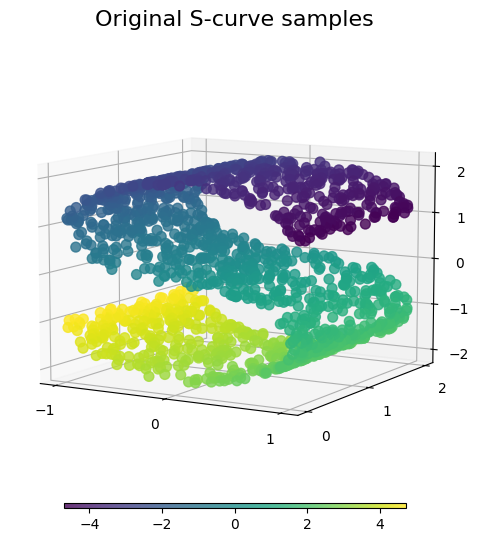

In [2]:
# %%
# Dataset preparation
# -------------------
#
# We start by generating the S-curve dataset.

import matplotlib.pyplot as plt
from matplotlib import ticker

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

from sklearn import manifold, datasets

n_samples = 1500
S_points, S_color = datasets.make_s_curve(n_samples, random_state=0)

# %%
# Let's look at the original data. Also define some helping
# functions, which we will use further on.


def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())


plot_3d(S_points, S_color, "Original S-curve samples")

In [3]:
# added PCA
from sklearn.decomposition import PCA, KernelPCA

In [4]:
pca = PCA(n_components=2)
pca_embed = pca.fit_transform(S_points)

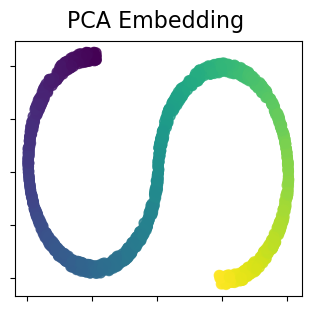

In [4]:
plot_2d(pca_embed, S_color, "PCA Embedding")

In [5]:
kernel_pca = KernelPCA(
    n_components=2, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
)
kpca_embed = pca.fit_transform(S_points)

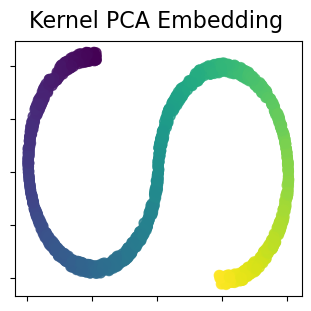

In [6]:
plot_2d(kpca_embed, S_color, "Kernel PCA Embedding")

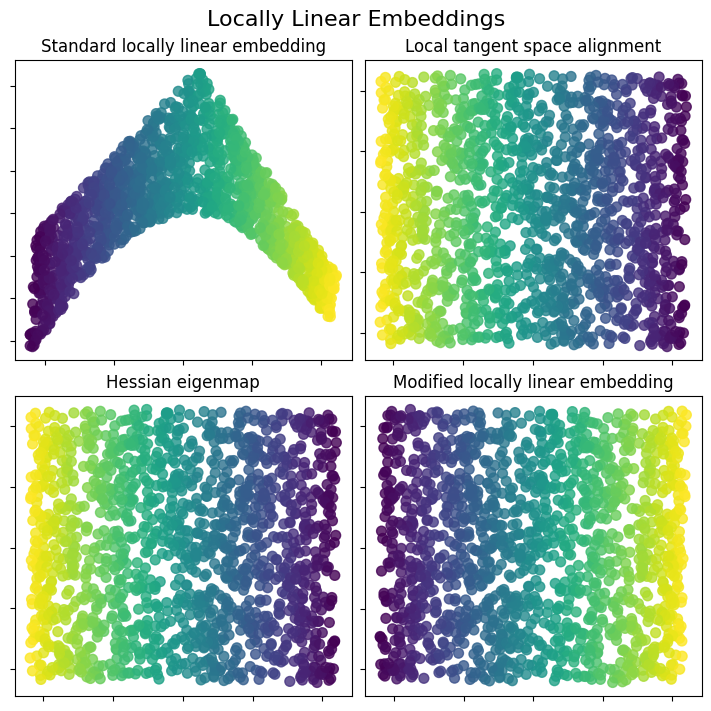

In [17]:
# %%
# Define algorithms for the manifold learning
# -------------------------------------------
#
# Manifold learning is an approach to non-linear dimensionality reduction.
# Algorithms for this task are based on the idea that the dimensionality of
# many data sets is only artificially high.
#
# Read more in the :ref:`User Guide <manifold>`.

n_neighbors = 12  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold

# %%
# Locally Linear Embeddings
# ^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Locally linear embedding (LLE) can be thought of as a series of local
# Principal Component Analyses which are globally compared to find the
# best non-linear embedding.
# Read more in the :ref:`User Guide <locally_linear_embedding>`.

params = {
    "n_neighbors": n_neighbors,
    "n_components": n_components,
    "eigen_solver": "auto",
    "random_state": 0,
}

lle_standard = manifold.LocallyLinearEmbedding(method="standard", **params)
S_standard = lle_standard.fit_transform(S_points)

lle_ltsa = manifold.LocallyLinearEmbedding(method="ltsa", **params)
S_ltsa = lle_ltsa.fit_transform(S_points)

lle_hessian = manifold.LocallyLinearEmbedding(method="hessian", **params)
try: 
    S_hessian = lle_hessian.fit_transform(S_points)
except: 
    print("Error for method='hessian', n_neighbors must be greater than [n_components * (n_components + 3) / 2]")
    S_hessian = None
    
lle_mod = manifold.LocallyLinearEmbedding(method="modified", **params)
S_mod = lle_mod.fit_transform(S_points)

# %%
fig, axs = plt.subplots(
    nrows=2, ncols=2, figsize=(7, 7), facecolor="white", constrained_layout=True
)
fig.suptitle("Locally Linear Embeddings", size=16)

lle_methods = [
    ("Standard locally linear embedding", S_standard),
    ("Local tangent space alignment", S_ltsa),
    ("Hessian eigenmap", S_hessian),
    ("Modified locally linear embedding", S_mod),
]
for ax, method in zip(axs.flat, lle_methods):
    name, points = method
    if points is not None:
        if n_components==2:
            add_2d_scatter(ax, points, S_color, name)
        else:
            plot_3d(points,S_color,name)
plt.show()

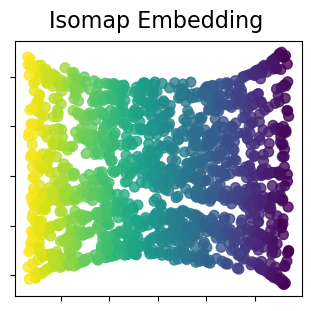

In [8]:
# %%
# Isomap Embedding
# ^^^^^^^^^^^^^^^^
#
# Non-linear dimensionality reduction through Isometric Mapping.
# Isomap seeks a lower-dimensional embedding which maintains geodesic
# distances between all points. Read more in the :ref:`User Guide <isomap>`.

isomap = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components, p=1)
S_isomap = isomap.fit_transform(S_points)

plot_2d(S_isomap, S_color, "Isomap Embedding")

/home/muller/miniconda3/envs/visual/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


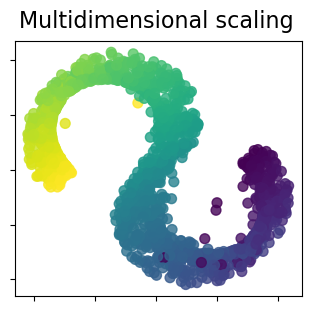

In [9]:
# %%
# Multidimensional scaling
# ^^^^^^^^^^^^^^^^^^^^^^^^
#
# Multidimensional scaling (MDS) seeks a low-dimensional representation
# of the data in which the distances respect well the distances in the
# original high-dimensional space.
# Read more in the :ref:`User Guide <multidimensional_scaling>`.

md_scaling = manifold.MDS(
    n_components=n_components,
    max_iter=50,
    n_init=4,
    random_state=0,
    #normalized_stress=False,
)
S_scaling = md_scaling.fit_transform(S_points)

plot_2d(S_scaling, S_color, "Multidimensional scaling")

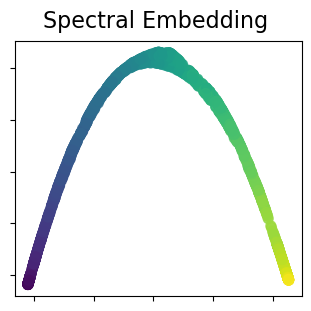

In [10]:
# %%
# Spectral embedding for non-linear dimensionality reduction
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# This implementation uses Laplacian Eigenmaps, which finds a low dimensional
# representation of the data using a spectral decomposition of the graph Laplacian.
# Read more in the :ref:`User Guide <spectral_embedding>`.

spectral = manifold.SpectralEmbedding(
    n_components=n_components, n_neighbors=n_neighbors
)
S_spectral = spectral.fit_transform(S_points)

plot_2d(S_spectral, S_color, "Spectral Embedding")

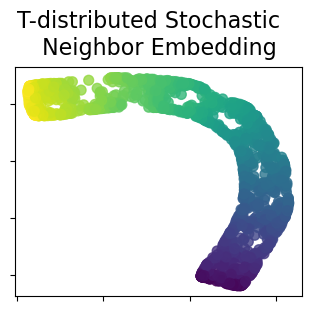

In [11]:
# %%
# T-distributed Stochastic Neighbor Embedding
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# It converts similarities between data points to joint probabilities and
# tries to minimize the Kullback-Leibler divergence between the joint probabilities
# of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost
# function that is not convex, i.e. with different initializations we can get
# different results. Read more in the :ref:`User Guide <t_sne>`.

t_sne = manifold.TSNE(
    n_components=n_components,
    perplexity=30,
    init="random",
    n_iter=250,
    random_state=0,
)
S_t_sne = t_sne.fit_transform(S_points)

plot_2d(S_t_sne, S_color, "T-distributed Stochastic  \n Neighbor Embedding")

# %%

In [12]:
# Added UMAP 
import umap
reducer = umap.UMAP(n_components=n_components,
                    n_neighbors = 15,
                    metric='euclidean',
                    random_state=42)

2024-02-12 16:40:34.515612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 16:40:34.612225: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-12 16:40:34.612244: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-12 16:40:35.206765: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [13]:
#help(umap.UMAP)

In [14]:
%time umap_projection = reducer.fit_transform(S_points)

CPU times: user 8.68 s, sys: 1.04 s, total: 9.72 s
Wall time: 7.97 s


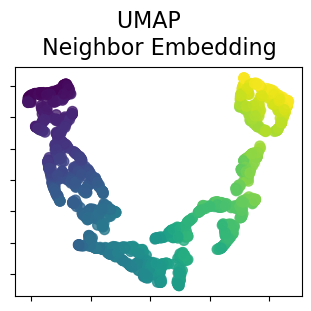

In [15]:
plot_2d(umap_projection, S_color, "UMAP  \n Neighbor Embedding")